In [1]:
import geopandas as gpd
import rasterio
import numpy as np
from rasterio.plot import show
from pathlib import Path
from tqdm import tqdm
import concurrent.futures

In [2]:
df = gpd.read_file('coherence_tiles.geojson')
df.head()

,bucket,key,tile_id,season,geometry
0,sentinel-1-global-coherence-earthbigdata,data/tiles/N00E005/N00E005_fall_vv_COH12.tif,N00E005,fall,"POLYGON ((6.00000 -1.00000, 6.00000 0.00000, 5..."
1,sentinel-1-global-coherence-earthbigdata,data/tiles/N00E005/N00E005_spring_vv_COH12.tif,N00E005,spring,"POLYGON ((6.00000 -1.00000, 6.00000 0.00000, 5..."
2,sentinel-1-global-coherence-earthbigdata,data/tiles/N00E005/N00E005_summer_vv_COH12.tif,N00E005,summer,"POLYGON ((6.00000 -1.00000, 6.00000 0.00000, 5..."
3,sentinel-1-global-coherence-earthbigdata,data/tiles/N00E005/N00E005_winter_vv_COH12.tif,N00E005,winter,"POLYGON ((6.00000 -1.00000, 6.00000 0.00000, 5..."
4,sentinel-1-global-coherence-earthbigdata,data/tiles/N00E006/N00E006_fall_vv_COH12.tif,N00E006,fall,"POLYGON ((7.00000 -1.00000, 7.00000 0.00000, 6..."


In [3]:
df_na_opera = gpd.read_file('opera-north-america.geojson')
na_opera_geo = df_na_opera.geometry.unary_union

In [4]:
df_na = df[df.geometry.intersects(na_opera_geo)].reset_index(drop=True)
df_na.head()

,bucket,key,tile_id,season,geometry
0,sentinel-1-global-coherence-earthbigdata,data/tiles/N08W078/N08W078_fall_vv_COH12.tif,N08W078,fall,"POLYGON ((-77.00000 7.00000, -77.00000 8.00000..."
1,sentinel-1-global-coherence-earthbigdata,data/tiles/N08W078/N08W078_spring_vv_COH12.tif,N08W078,spring,"POLYGON ((-77.00000 7.00000, -77.00000 8.00000..."
2,sentinel-1-global-coherence-earthbigdata,data/tiles/N08W078/N08W078_summer_vv_COH12.tif,N08W078,summer,"POLYGON ((-77.00000 7.00000, -77.00000 8.00000..."
3,sentinel-1-global-coherence-earthbigdata,data/tiles/N08W078/N08W078_winter_vv_COH12.tif,N08W078,winter,"POLYGON ((-77.00000 7.00000, -77.00000 8.00000..."
4,sentinel-1-global-coherence-earthbigdata,data/tiles/N08W079/N08W079_fall_vv_COH12.tif,N08W079,fall,"POLYGON ((-78.00000 7.00000, -78.00000 8.00000..."


In [5]:
len(df_na.tile_id.unique())

1907

In [6]:
df_tiles = df_na[['tile_id', 'key', 'bucket']].groupby('tile_id').agg(dict(key=list,
                                                              bucket='first')).reset_index(drop=False)
tile_data = df_tiles.to_dict('records')
tile_data[:2]

[{'tile_id': 'N08W078',
  'key': ['data/tiles/N08W078/N08W078_fall_vv_COH12.tif',
   'data/tiles/N08W078/N08W078_spring_vv_COH12.tif',
   'data/tiles/N08W078/N08W078_summer_vv_COH12.tif',
   'data/tiles/N08W078/N08W078_winter_vv_COH12.tif'],
  'bucket': 'sentinel-1-global-coherence-earthbigdata'},
 {'tile_id': 'N08W079',
  'key': ['data/tiles/N08W079/N08W079_fall_vv_COH12.tif',
   'data/tiles/N08W079/N08W079_spring_vv_COH12.tif',
   'data/tiles/N08W079/N08W079_summer_vv_COH12.tif',
   'data/tiles/N08W079/N08W079_winter_vv_COH12.tif'],
  'bucket': 'sentinel-1-global-coherence-earthbigdata'}]

In [7]:
def read_one_coherence(bucket, key):
    with rasterio.open(f's3://{bucket}/{key}') as ds:
        X = ds.read(1)
        p = ds.profile
    return X, p
    
def get_coherence_for_tile(record: dict) -> tuple[np.ndarray, dict]:
    keys = record['key']
    bucket = record['bucket']
    read_one_coherence_p = lambda key: read_one_coherence(bucket, key)
    data = list(map(read_one_coherence_p, keys))
    arrays, profiles = zip(*data)
    mean_coh = np.mean(arrays, axis=0)
    return mean_coh, profiles[0]

def get_mask_for_tile(record: dict, threshold=70) -> tuple:
    mean_coh, p = get_coherence_for_tile(record)
    mask = (mean_coh >= threshold).astype('uint8')
    return mask, p

In [8]:
X, p = get_mask_for_tile(tile_data[100])

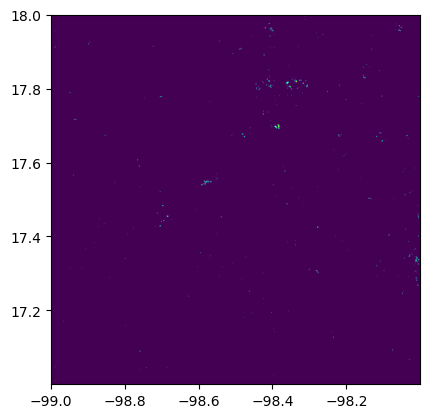

<Axes: >

In [9]:
show(X, transform=p['transform'])

In [10]:
tile_dir = Path('annual_avg_coherence_tiles')
tile_dir.mkdir(exist_ok=True, parents=True)

In [11]:
def serialize_one(record: dict) -> Path:
    X, p = get_mask_for_tile(record)
    tile_id = record['tile_id']
    out_path = tile_dir / f'{tile_id}.tif'
    with rasterio.open(out_path, 'w', **p) as ds:
        ds.write(X, 1)
    return out_path

In [122]:
# paths = list(map(serialize_one, tqdm(tile_data)))

In [121]:
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    paths = list(tqdm(executor.map(serialize_one, tile_data[:]), total=len(tile_data)))

100%|███████████| 1907/1907 [29:13<00:00,  1.09it/s]
